### Asignment 6 - Deep Learning

#### Beltrán Liniers  nº57646

#### Luís Santos nº57470

### Problem 1 -- Testar CNN com as suas diferentes possibilidades

No primeiro exercício o que vamos treinar é uma rede neuronal convolucional para classificar uma série de imagens de flores, o objetivo é localizar as rosas. 

Entre as possibilidades que ofrece o package Keras-TensorFlow para o treino de uma CNN, nós vamos analisar os diferentes resultados que se obtêm quando:

 - Usamos o Mean Squared Error como loss function
 - A probabildade dropout (40%);
 - O tamanho do Batch;
 - Batch Normalization;
 - E combinação dos pontos 2, 3 e 4 anteriormente referidos
Durante as várias experiências, vamos analisar as curvas da loss function e a accuracy, controlando o overfitting e o tempo médio por epoch.

Primeiramente importamos os packages necessários e o dataset do tutorial de classificação de imagens do Tensorflow.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
#from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 4s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Dividimos a base de dados em duas partes, traino e validação, com um 80% e 20%.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


A variável dependente conta com 5 categorias diferentes:
 - Daisy, Dandelion, Sunflowers, Tulips and Roses.

Imprimimos uma pequena amostra para ajudar a perceber as diferencias que elas têm.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


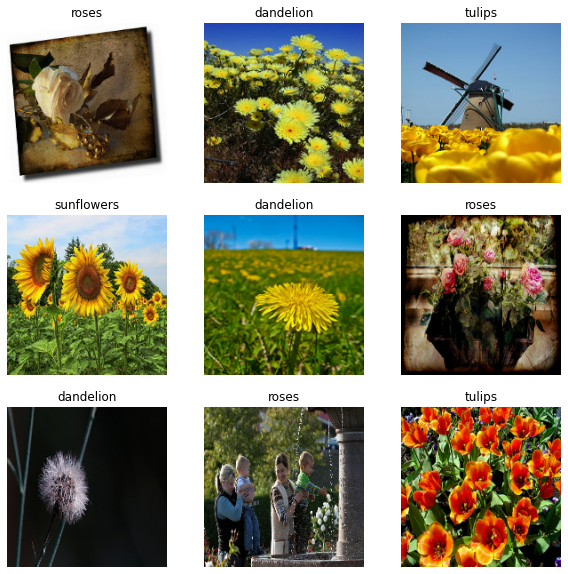

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Um dos principais desafios quando se treinam modelos de classificação de imagens é o desemplenho computacional. Para isso usam-se dois métodos que permitem armazenar as imagens em memória depois de serem carregadas(`cache`) e priorizar a execução do modelo (`prefetch`).

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def plot_train_val(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

O overfitting é uma das principais preocupações quando se contrói um modelo de aprendizagem profunda. No treinamento de redes convolucionais existem duas maneiras de obter um modelo que permita generalizar a outros conjuntos de dados:
 - O aumento de dados: Replicam-se as imagens com pequenas alterações, por exemplo rodar a imagen, deslocá-la alguns pixeles ou aplicar zoom. Estas imagens são selecionadas ao acaso.
 - Dropout: De maneira aleatória, alguns neurónios e as suas correspondentes ligações não são tidas em conta.

O aumento de dados vai se implementar desde o início, antes de treinar o modelo. No entanto o dropout pode ser aplicado nas diferentes camadas da CNN. De qualquer das maneiras, estas duas técnicas são aplicadas exclusivamente no conjunto de treino, nunca quando vamos clasificar uma nova imagem.

A continuação aplicamos o data augmentation.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

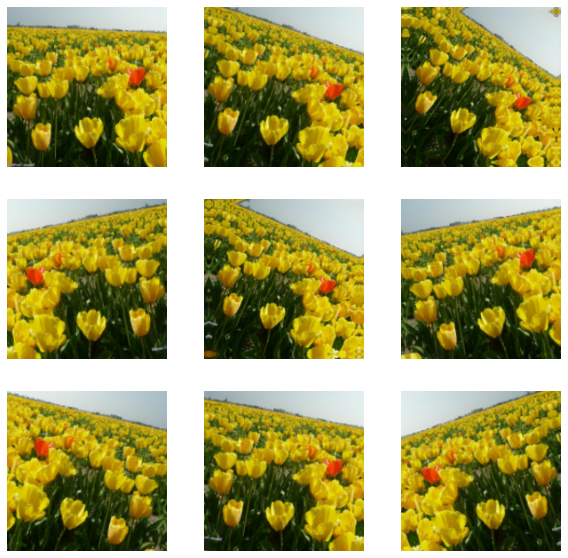

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Outro aspeto importante que pode otimizar o treino da rede convolucional é padronizar os dados. A forma que nós escolhemos é a criar uma camada dentro da definição da CNN, usando o método `Rescaling`. 

O paso a seguir é a definição da rede convulcional. Isto consiste em definir as caraterísticas das camadas e o pooling, assim como o número delas.

A primeira camada, como indicámos anteriormente, aplica a normalização (`Rescaling`). A continuação aplicam-se 3 convulsões(`Conv2D`) com 16, 32 e 64 filtros respeitivamente, usando uma função de ativação ReLU. Cada uma das convulções é seguida de um `MaxPooling2D`, o qual permite a redução da dimensionalidade das imagens.

Mais tarde é aplicado um `dropout` de 0.2. Existem muitas discussões sobre onde é mais efetivo colocar este tipo de regularização e qual o efeito do dropout numa CNN. Para alguns é apontado que numa CNN o resultado do drop out não é igual a de uma rede feedforward, na realidade pode não desativar realmente determinados neurónios [1].

In [ ]:
#BASE MODEL
num_classes = len(class_names)
base_model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
base_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 50
history = base_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
92/92 [==============================] - 26s 70ms/step - loss: 1.3004 - accuracy: 0.4356 - val_loss: 1.0664 - val_accuracy: 0.5531
Epoch 2/50
92/92 [==============================] - 5s 53ms/step - loss: 1.0342 - accuracy: 0.5838 - val_loss: 1.0294 - val_accuracy: 0.5804
Epoch 3/50
92/92 [==============================] - 5s 52ms/step - loss: 0.9094 - accuracy: 0.6522 - val_loss: 0.8992 - val_accuracy: 0.6676
Epoch 4/50
92/92 [==============================] - 5s 52ms/step - loss: 0.8420 - accuracy: 0.6717 - val_loss: 0.9349 - val_accuracy: 0.6608
Epoch 5/50
92/92 [==============================] - 5s 53ms/step - loss: 0.7837 - accuracy: 0.6989 - val_loss: 0.9097 - val_accuracy: 0.6512
Epoch 6/50
92/92 [==============================] - 5s 52ms/step - loss: 0.7604 - accuracy: 0.7027 - val_loss: 0.7859 - val_accuracy: 0.7098
Epoch 7/50
92/92 [==============================] - 5s 52ms/step - loss: 0.7198 - accuracy: 0.7289 - val_loss: 0.7762 - val_accuracy: 0.7030
Epoch 8/50
9

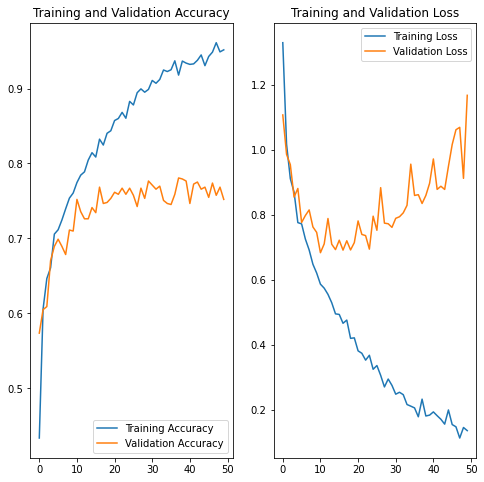

In [ ]:
plot_train_val(history)

Analisando ambos, o output de treino do modelo base e os gráficos apresentados, é possível observar que o tempo médio por epoch é de 5 segundos. Analisando a curva de aprendizagem para o training e validation set. Elenca-se que o overfitting do modelo começa acontecer após as 10 epochs.

### Problema 1 Exercício i

A primeira experiência consiste em validar o modelo definindo o erro quadratico médio como loss function. 

In [ ]:
model_i = base_model
model_i.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [ ]:
model_i.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 50
history_i = model_i.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
92/92 [==============================] - 7s 56ms/step - loss: 7.1605 - accuracy: 0.2619 - val_loss: 2.0776 - val_accuracy: 0.1703
Epoch 2/50
92/92 [==============================] - 5s 54ms/step - loss: 1.8155 - accuracy: 0.1952 - val_loss: 1.6957 - val_accuracy: 0.1948
Epoch 3/50
92/92 [==============================] - 5s 56ms/step - loss: 1.5691 - accuracy: 0.2282 - val_loss: 1.4100 - val_accuracy: 0.2384
Epoch 4/50
92/92 [==============================] - 5s 54ms/step - loss: 1.3938 - accuracy: 0.2480 - val_loss: 1.3288 - val_accuracy: 0.2016
Epoch 5/50
92/92 [==============================] - 5s 54ms/step - loss: 1.2641 - accuracy: 0.2333 - val_loss: 1.2481 - val_accuracy: 0.1948
Epoch 6/50
92/92 [==============================] - 5s 55ms/step - loss: 1.1805 - accuracy: 0.2204 - val_loss: 1.2128 - val_accuracy: 0.1907
Epoch 7/50
92/92 [==============================] - 5s 53ms/step - loss: 1.1617 - accuracy: 0.2347 - val_loss: 1.2161 - val_accuracy: 0.1921
Epoch 8/50
92

Os resultados obtidos são muito pobres em termos do accuracy. Tanto com os dados de treino como com os de validação o accuracy apenas chega a 0.3. Outro ponto a destacar é o comportamento aleatório que tem o accuracy ao longo das épocas, tanto no treino como na validação.

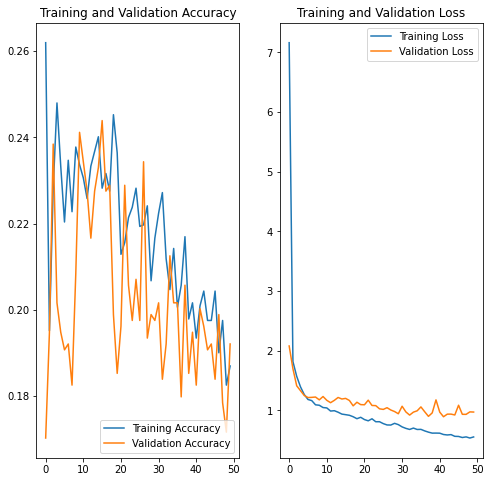

In [ ]:
plot_train_val(history_i)

Como é possível observar a seleção do MSE como loss function levou a um deteriormento da performance do modelo. Sendo que o comportamento da accuracy é bastante irregular com picos ao longo das epochs, mas com tendência para ir descrescendo ao longo das epochs. O mesmo comportamento é observado para a loss function.

### Exercício ii

Neste caso, o modelo vai ser definido novamente, a diferença é o nível do dropout. Anteriormente tínhamos-o definido por defeito em 0.2. Para a próxima experiência aplicamos um 0.4.

Também vamos alterar a função loss. Passaremos a usar a Sparse categorical Cross entropy.

In [ ]:
model_ii = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model_ii.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 50
history_ii = model_ii.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
92/92 [==============================] - 7s 60ms/step - loss: 1.3496 - accuracy: 0.4176 - val_loss: 1.0901 - val_accuracy: 0.5545
Epoch 2/50
92/92 [==============================] - 5s 54ms/step - loss: 1.0721 - accuracy: 0.5616 - val_loss: 0.9858 - val_accuracy: 0.6104
Epoch 3/50
92/92 [==============================] - 5s 54ms/step - loss: 0.9657 - accuracy: 0.6233 - val_loss: 0.9176 - val_accuracy: 0.6471
Epoch 4/50
92/92 [==============================] - 5s 54ms/step - loss: 0.8863 - accuracy: 0.6594 - val_loss: 0.9577 - val_accuracy: 0.6267
Epoch 5/50
92/92 [==============================] - 5s 54ms/step - loss: 0.8397 - accuracy: 0.6768 - val_loss: 0.8811 - val_accuracy: 0.6744
Epoch 6/50
92/92 [==============================] - 5s 54ms/step - loss: 0.8076 - accuracy: 0.6955 - val_loss: 0.7980 - val_accuracy: 0.6785
Epoch 7/50
92/92 [==============================] - 5s 54ms/step - loss: 0.7495 - accuracy: 0.7149 - val_loss: 0.7711 - val_accuracy: 0.6948
Epoch 8/50
92

Os resultados são muito melhores. A partir da sétima epoch o accuracy atinge os 0.7, superando os 0.76 ao final da execução (50º epoch). Semelhante ao modelo base, nunca atinge o 0.8 de accuracy. 

É a partir da época 20º que o modelo começa a dar sintomas de overfitting, isto nota-se em que a diferencia ente o accuracy de treino e de validação começa a aumentar (O de validação deixa de crescer). Analisando a validation loss, vemos que é a partir desta época que deixa de descer. 

Percebe-se que, no geral, este modelo é muito melhor devido também a que o comportamento do accuracy é muito mais estável que no modelo anterior, crescendo ambas accuracy de maneira sincronizada e sem comportamentos erráticos.



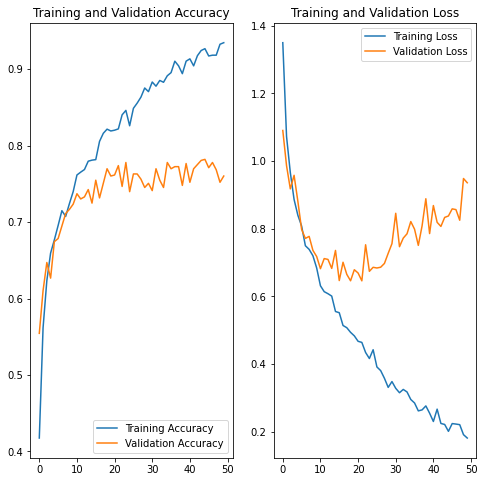

In [ ]:
plot_train_val(history_ii)

### Exercício iii
Normalmente, para otimizar o rendimento computacional, a CNN não procesa todas as imagens de uma só vez, mas em grupos denominados batch. Conforma-se o batch a partir de uma amostra aleatória do nosso conjunto de treino. Se o tamanho do batch for muito pequeno a variância ia ser muito alta dentro de cada batch, se for muito grande o GPU pode demorar muito tempo a treinar o modelo. No entanto, a razão pela que não aumentamos o tamanho do batch até o máximo é porque é provado que o Stochastic Gradient Descent funciona bem sem necessidade de grandes amostras. Por defeito o tamanho do batch é de 32.

Nesta alínea vai-se definir como 8 o tamanho do batch. Com isto significa que em cada iteração da rede convolucional, vai ser treinada com 8 imagens, corresponendo a um total de 92 iterações que vão compor uma epoch.

In [ ]:
epochs=50
history_iii = base_model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      batch_size=8)

Epoch 1/50
92/92 [==============================] - 6s 56ms/step - loss: 0.5186 - accuracy: 0.1809 - val_loss: 0.9540 - val_accuracy: 0.1866
Epoch 2/50
92/92 [==============================] - 5s 54ms/step - loss: 0.4951 - accuracy: 0.1979 - val_loss: 0.9252 - val_accuracy: 0.1812
Epoch 3/50
92/92 [==============================] - 5s 54ms/step - loss: 0.5055 - accuracy: 0.2054 - val_loss: 1.0016 - val_accuracy: 0.1839
Epoch 4/50
92/92 [==============================] - 5s 54ms/step - loss: 0.5020 - accuracy: 0.2084 - val_loss: 0.9450 - val_accuracy: 0.1880
Epoch 5/50
92/92 [==============================] - 5s 54ms/step - loss: 0.4965 - accuracy: 0.1836 - val_loss: 0.9974 - val_accuracy: 0.1689
Epoch 6/50
92/92 [==============================] - 5s 54ms/step - loss: 0.4825 - accuracy: 0.1901 - val_loss: 1.0391 - val_accuracy: 0.1730
Epoch 7/50
92/92 [==============================] - 5s 53ms/step - loss: 0.4940 - accuracy: 0.1877 - val_loss: 0.8725 - val_accuracy: 0.1826
Epoch 8/50
92

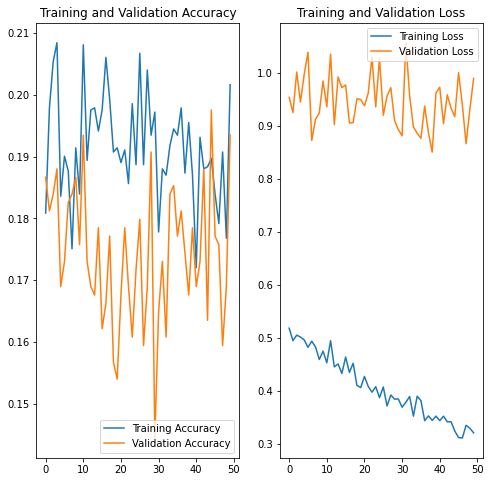

In [ ]:
plot_train_val(history_iii)

Os resultados obtidos ao alterar o tamanho do batch pioraram o modelo base. Analisando o loss function do validation set, o modelo nunca foi capaz baixar dos 0.8. Demonstrando a incapacidade de aprender.

### Exercício iv

A batch normalization é uma técnica aplicada entre as camadas da rede neuronal. Consiste em substrair a média e dividir pelo desvio padrão o output da camada anterior, antes de se introduzirem os dados na função de ativação. Entre as principais ventagens da normalização batch estão o aumento do learning rate, a reducção do covariate shift e o ligeiro efeito regularizador que tem o BN [2]. 

Nesta alínea vai se implementar ao modelo base o batch normalization.


In [ ]:
model_iv = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model_iv.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=50
history_iv = model_iv.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      batch_size=8)

Epoch 1/50
92/92 [==============================] - 8s 60ms/step - loss: 2.3052 - accuracy: 0.4329 - val_loss: 16.3147 - val_accuracy: 0.2398
Epoch 2/50
92/92 [==============================] - 8s 82ms/step - loss: 1.1934 - accuracy: 0.5364 - val_loss: 13.0242 - val_accuracy: 0.2507
Epoch 3/50
92/92 [==============================] - 6s 64ms/step - loss: 1.0985 - accuracy: 0.5800 - val_loss: 4.9387 - val_accuracy: 0.3379
Epoch 4/50
92/92 [==============================] - 5s 55ms/step - loss: 1.0432 - accuracy: 0.5943 - val_loss: 1.5367 - val_accuracy: 0.5014
Epoch 5/50
92/92 [==============================] - 5s 54ms/step - loss: 0.9529 - accuracy: 0.6291 - val_loss: 1.0629 - val_accuracy: 0.5858
Epoch 6/50
92/92 [==============================] - 5s 55ms/step - loss: 0.9087 - accuracy: 0.6458 - val_loss: 0.9918 - val_accuracy: 0.6253
Epoch 7/50
92/92 [==============================] - 5s 55ms/step - loss: 0.8754 - accuracy: 0.6649 - val_loss: 0.9590 - val_accuracy: 0.6281
Epoch 8/50


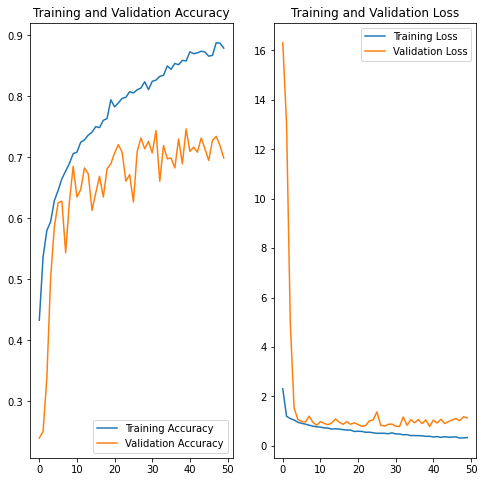

In [ ]:
plot_train_val(history_iv)

Com o batch normalization, a curva do accuracy para o teste de validação apresentou uma tendência crescente ao longo das 50 epochs. Por outro lado, também teve impacto na curva da loss function. Onde esta apresentou um decrescimento abrupto nas primeiras 10 epochs e teve a estabilizar ao longo das epochs restantes. Apenas nas últimas epochs começa-se a verificar um ligeiro comportamento de overfitting, mas muito menos pronunciado que nos casos anteriores.

### Exercício V
Neste exercício vai se combinar as alterações feitas nos ponto ii, iii e iv e treinar um novo modelo

In [ ]:
model_v = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model_v.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=50
history_v = model_v.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      batch_size=8)

Epoch 1/50
92/92 [==============================] - 7s 58ms/step - loss: 1.9773 - accuracy: 0.4475 - val_loss: 21.6833 - val_accuracy: 0.2398
Epoch 2/50
92/92 [==============================] - 5s 55ms/step - loss: 1.1563 - accuracy: 0.5351 - val_loss: 14.6357 - val_accuracy: 0.2398
Epoch 3/50
92/92 [==============================] - 5s 55ms/step - loss: 1.0718 - accuracy: 0.5807 - val_loss: 6.1611 - val_accuracy: 0.2779
Epoch 4/50
92/92 [==============================] - 5s 55ms/step - loss: 1.0042 - accuracy: 0.6298 - val_loss: 1.4560 - val_accuracy: 0.4455
Epoch 5/50
92/92 [==============================] - 5s 56ms/step - loss: 0.9312 - accuracy: 0.6434 - val_loss: 1.2024 - val_accuracy: 0.5354
Epoch 6/50
92/92 [==============================] - 5s 55ms/step - loss: 0.8554 - accuracy: 0.6686 - val_loss: 0.9080 - val_accuracy: 0.6403
Epoch 7/50
92/92 [==============================] - 5s 55ms/step - loss: 0.8592 - accuracy: 0.6843 - val_loss: 0.8932 - val_accuracy: 0.6580
Epoch 8/50


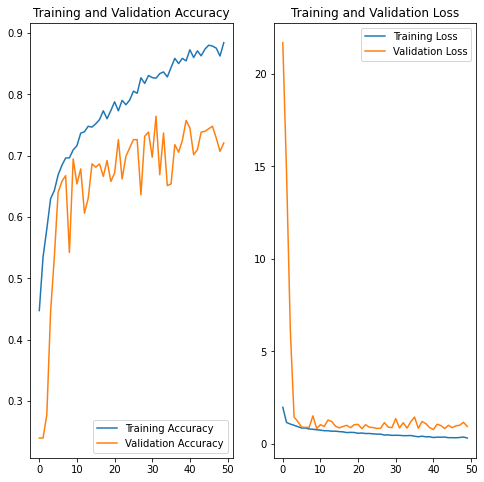

In [ ]:
plot_train_val(history_v)

Verificamos que combinando as várias alterações feitas ao modelo base, permitiram criar um modelo com menos tendência para o overfitting, capaz de convergir para os valores esperados.

Contudo, o último modelo que combina o dropout a 0.4, o batch size igual a 8 e a batch normalization obtém um accuracy bastante bom, classificando bem mais de um 71% das observações de valdiação. No entanto, pensamos que o modelo pode ser melhorado se aumentarmos o batch size, já que a sua parametrização em 8 não melhorou o modelo.

### Problema 2

No segundo exercício vamos aplicar um autoencoder. Esta técnica de rede neuronal está pensada para reduzir a dimensionalidade das imagens, no nosso caso. Para tal redução, codifica-se a imagem numa representação latente. A seguir, a imagem é decodificada. A imagem inicial e a reconstruída são comparadas, as diferencias encontradas entre ambas imagens são denominadas erros de reconstrução, os quais são usado para treinar o modelo.

Para desenvolver o Autoencoder vamos usar o mesmo conjunto de dados das flores.

Primeiramente vamos dividir em dados de treino e de validação

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=1-(3500/3670),
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=1-(3500/3670),
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 3500 files for training.
Found 3670 files belonging to 5 classes.
Using 170 files for validation.


Posteriormente, os labels subjacentes às imagens serão retirados, pois trata-se de um problema de unsupervised learning. Seguidamente, os dados são normalizados, de maneira a que os valores dos pixeis sejam centrados entre 0 e 1.

In [ ]:
train_ds = np.concatenate([x for x, y in train_ds], axis=0)
validation_ds = np.concatenate([x for x, y in validation_ds], axis=0)

train_ds = train_ds.astype('float32') / 255
validation_ds = validation_ds.astype('float32') / 255

Porque neste preciso o momento os nossos dados são do tipo numpy array, será realizada a sua conversão para tensor.

In [ ]:
train_ds = tf.reshape(tf.convert_to_tensor(train_ds),[3500,img_height,img_width,3])
validation_ds = tf.reshape(tf.convert_to_tensor(validation_ds),[170,img_height,img_width,3])

### Exercício a)

Definimos a classe autoencoder, a qual inclui o codificador e o decodificador. Ambas redes têm diferente número de camadas e filtros. Em ambos os casos foram usadas funções de ativação ReLU. Quando as imagens são codificadas é usado o método MaxPooling para a redução da dimensionalidade, no caso da decodificação o método usado é o UpSampling. Sendo que esta arquitetura é baseada no exemplo apresentado do tutorial do keras [3]. Foram experimentadas diferentes autoencoders com diferentes configurações. 

Como loss function foi utilizado Binary Crossentropy.

Para entender o resultado das dimensões das imagens resultantes das convoluções e posteriormente das deconvoluções. Foram aplicados as seguintes formulas :

$I = Dimensão \ de \ Input$ 

$P = valor \ do \ padding$ 

$S = valor \ do \ stride$ 

$K = Tamanho \ do \ kernel$

Para convolução [4]:

${\frac{(I-K+2\times P)}{S}+1}$

Para MaxPooling [4]:

${\frac{(I-K)}{S}+1}$

Para deconvolução [5]:

$(I-1) \times S - 2\times P + (K - 1) + 1$



In [ ]:
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(180, 180, 3)),
      layers.Conv2D(16,(4,4),activation='relu',padding='same'),
      layers.MaxPooling2D((2, 2), padding='same'),
      layers.Conv2D(8, (4, 4), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2), padding='same'),
      layers.Conv2D(8, (4, 4), activation='relu', padding='same'),
      layers.Flatten()])
    self.decoder = tf.keras.Sequential([
      #layers.Dense(45*45*8,activation='relu'),
      #layers.Dropout(0.2),
      layers.Reshape((45,45,8)),
      layers.Conv2D(8, (4, 4), activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.UpSampling2D((2, 2)),
      layers.Conv2D(8, (4, 4), activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.UpSampling2D((2, 2)),
      layers.Conv2D(3, (4, 4), activation='sigmoid', padding='same')])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder()



In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.BinaryCrossentropy(from_logits=True))

In [ ]:
print(autoencoder.encoder.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 180, 180, 16)      784       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 90, 90, 8)         2056      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 45, 45, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 45, 45, 8)         1032      
                                                                 
 flatten_9 (Flatten)         (None, 16200)           

In [ ]:
autoencoder.fit(train_ds, train_ds,
                epochs=50,
                shuffle=True,
                batch_size = batch_size,
                validation_data=(validation_ds, validation_ds))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


110/110 [==============================] - 14s 122ms/step - loss: 0.5650 - val_loss: 0.5901
Epoch 2/50
110/110 [==============================] - 13s 117ms/step - loss: 0.5097 - val_loss: 0.5253
Epoch 3/50
110/110 [==============================] - 13s 117ms/step - loss: 0.4977 - val_loss: 0.4978
Epoch 4/50
110/110 [==============================] - 13s 118ms/step - loss: 0.4935 - val_loss: 0.4939
Epoch 5/50
110/110 [==============================] - 13s 117ms/step - loss: 0.4907 - val_loss: 0.4898
Epoch 6/50
110/110 [==============================] - 13s 117ms/step - loss: 0.4891 - val_loss: 0.4822
Epoch 7/50
110/110 [==============================] - 13s 117ms/step - loss: 0.4877 - val_loss: 0.4960
Epoch 8/50
110/110 [==============================] - 13s 117ms/step - loss: 0.4868 - val_loss: 0.4847
Epoch 9/50
110/110 [==============================] - 13s 116ms/step - loss: 0.4859 - val_loss: 0.4862
Epoch 10/50
110/110 [==============================] - 13s 117ms/step - loss: 0.4855

Para a construção do autoencoder foram definidas 50 epochs, na busca do modelo ótimo. Se analisamos os resultados, a função loss tem o seu valor mínimo na última epoch igual a 0.4698. Esta performance não é muito boa, já que indica que a reconstrução é práticamente aleatória.



Antes de mais, temos definido uma série de funções que vão ajudar-nos na resolução das diferentes experiências, especialmente add_noise que nos permite adicionar Gaussian Noise.

In [ ]:
def encode_images(imgs):
  return autoencoder.encoder(imgs)

def add_noise(noise_level,imgs):
  return layers.GaussianNoise(noise_level)(imgs,training=True)

def decode_images(imgs):
  return autoencoder.decoder(imgs)

def plot_images(imgs_orig,imgs_recon):
  n = len(imgs_recon)
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs_orig[i].numpy())
    plt.title("original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tf.squeeze(imgs_recon[i].numpy()))
    plt.title("reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

### Exercício b)

A continuação vamos selecionar 3 imagens de maneira aleatória com o objetivo de as analisar em detalhe, comparando a imagem original com a reconstruída. 

Train set


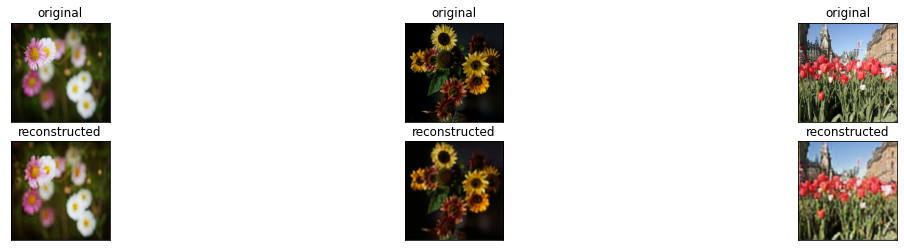

Validation set


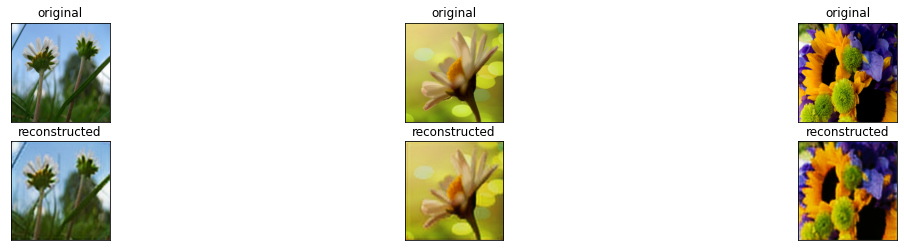

In [ ]:
print("Train set")
plot_images(train_ds[1000:1003],decode_images(encode_images(train_ds[1000:1003])))
print("Validation set")
plot_images(validation_ds[90:93],decode_images(encode_images(validation_ds[90:93])))

Analisando as imagens obtidas conseguimos verificar que as imagens reconstruídas quando comparadas com as originais, apresentam uma pior qualidade ao nível de definição. No entanto, estão bastante próximas das originais. Demonstrando que o encoder foi capaz de comprimir estas imagens num espaço latente que permite ao decoder reconstruir a partir desse espaço imagens semelhantes às originais.

### Exercício c)

A continuação vamos novamente analisar essas mesmas 3 imagens, comparando a imagem original com a reconstruída. Desta vez vamos adicionar ruído à imagem original, em 3 fases diferentes, aumentando o nível. A função `add_noise` vai ser aplicada depois de ser codificada e antes de ser descodificada.



Noise Level: 5%

Train set


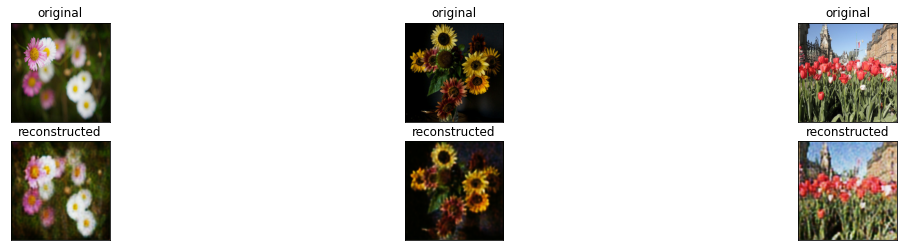

Validation set


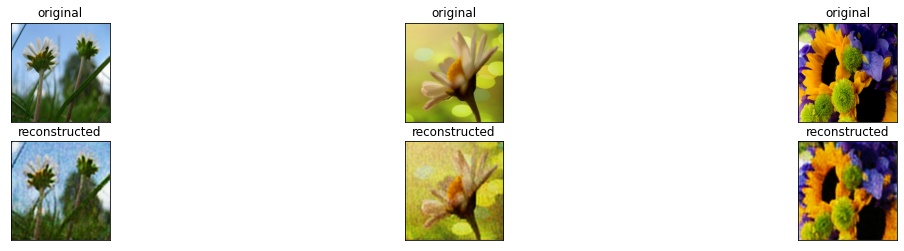

In [ ]:
print("Train set")
plot_images(train_ds[1000:1003],decode_images(add_noise(0.05,encode_images(train_ds[1000:1003]))))
print("Validation set")
plot_images(validation_ds[90:93],decode_images(add_noise(0.05,encode_images(validation_ds[90:93]))))

Com um nível de ruído de 0.05 nota-se alguma degradação das imagens reconstruídas.

Noise Level 10%

Train set


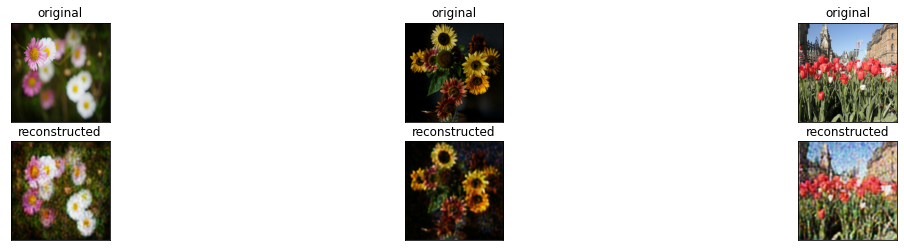

Validation set


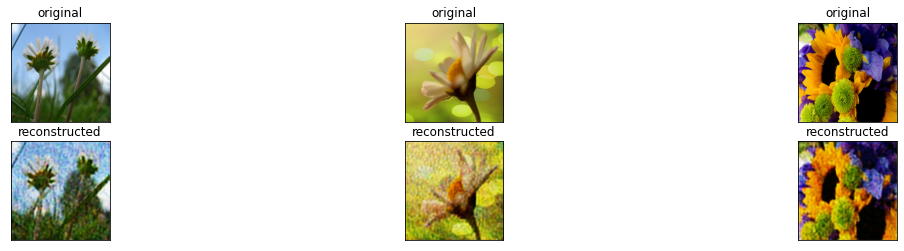

In [ ]:
print("Train set")
plot_images(train_ds[1000:1003],decode_images(add_noise(0.1,encode_images(train_ds[1000:1003]))))
print("Validation set")
plot_images(validation_ds[90:93],decode_images(add_noise(0.1,encode_images(validation_ds[90:93]))))

Noise Level: 20%

Train set


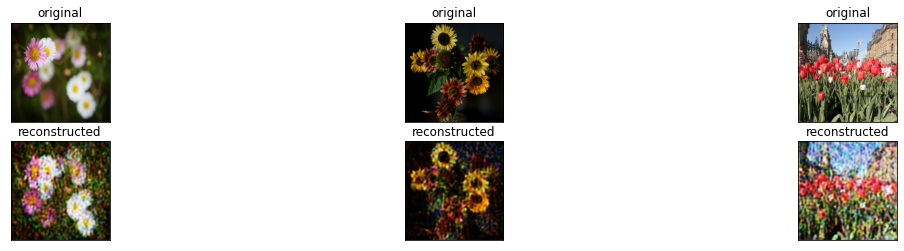

Validation set


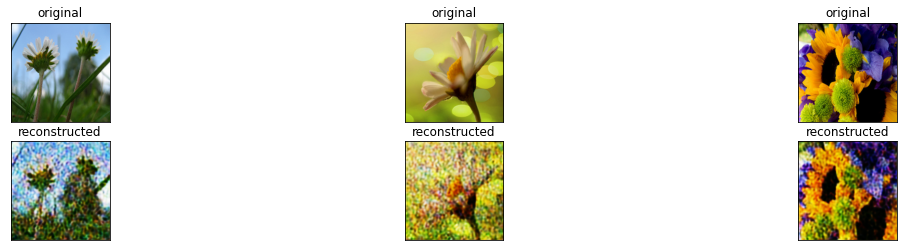

In [ ]:
print("Train set")
plot_images(train_ds[1000:1003],decode_images(add_noise(0.2,encode_images(train_ds[1000:1003]))))
print("Validation set")
plot_images(validation_ds[90:93],decode_images(add_noise(0.2,encode_images(validation_ds[90:93]))))

Pode-se ver que a medida que adicionamos ruído as reconstruções são aparentemente piores, como era de esperar. Sendo que com um ruído de 20%, a qualidade das imagens é muito baixa.

### Exercício d) 

Novamente vamos adicionar ruído às imagens, com a diferença em que a função geradora de ruído vai ser aplicada antes de codificar as imagens, ou seja, ao nível do input.

Noise Level 5%

Train set


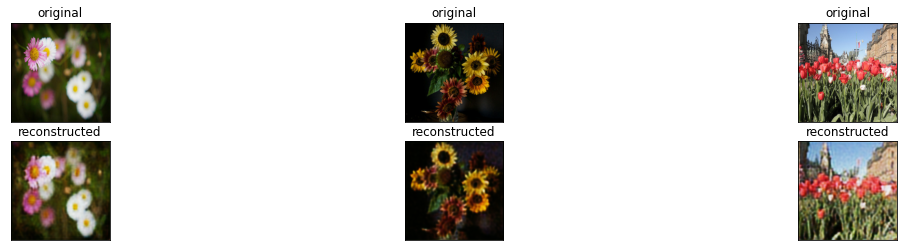

Validation set


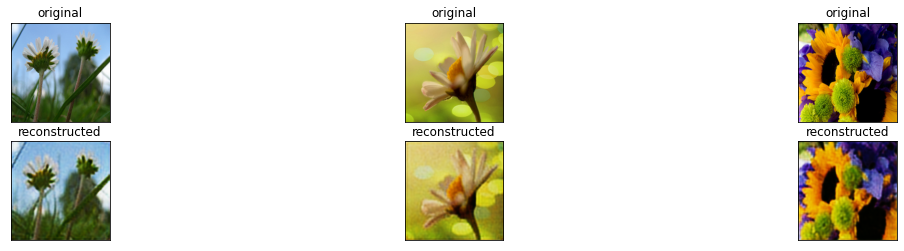

In [ ]:
print("Train set")
plot_images(train_ds[1000:1003],decode_images(encode_images(add_noise(0.05,train_ds[1000:1003]))))
print("Validation set")
plot_images(validation_ds[90:93],decode_images(encode_images(add_noise(0.05,validation_ds[90:93]))))



Noise Level 10%

Train set


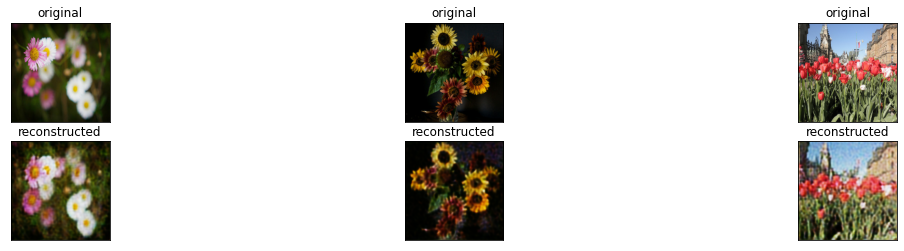

Validation set


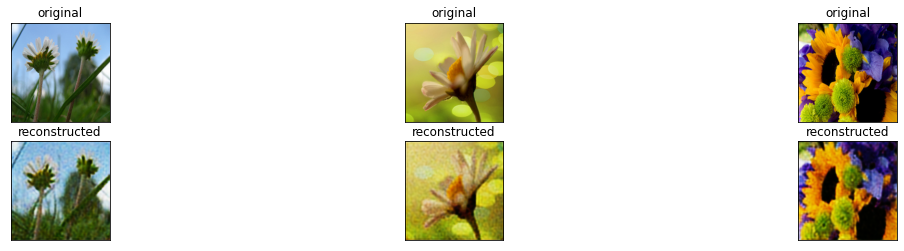

In [ ]:
print("Train set")
plot_images(train_ds[1000:1003],decode_images(encode_images(add_noise(0.1,train_ds[1000:1003]))))
print("Validation set")
plot_images(validation_ds[90:93],decode_images(encode_images(add_noise(0.1,validation_ds[90:93]))))

Noise Level 20%

Train set


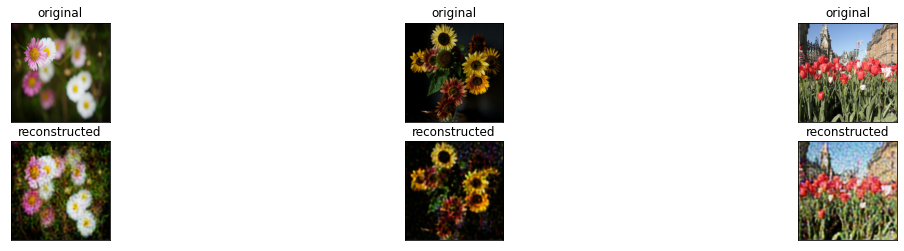

Validation set


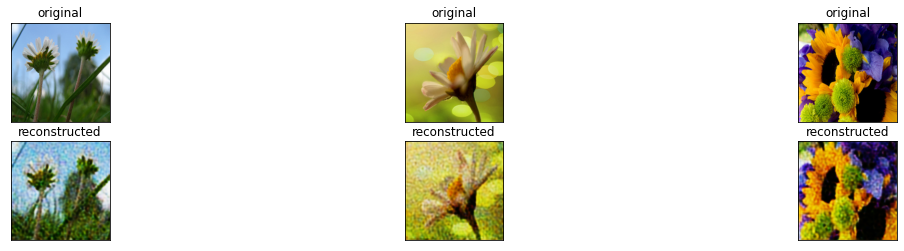

In [ ]:
print("Train set")
plot_images(train_ds[1000:1003],decode_images(encode_images(add_noise(0.2,train_ds[1000:1003]))))
print("Validation set")
plot_images(validation_ds[90:93],decode_images(encode_images(add_noise(0.2,validation_ds[90:93]))))

Comparando as reconstrucções das imagens nos dois momentos em que o ruído é adicionado, podemos concluir que quando aplicamos o ruído gaussiano antes da imagem ser codificada, a reconstrução parece ser melhor, estas estão menos desfocadas. Este comportamento faz sentido já que codificando uma imagem com ruído, este pode ser controlado, porém decodificar uma imagem com um modelo que não tinha previsto o ruído resulta numa reconstrução mais deficitária.

# Referências:
[1] Dropout on convolutional layers is weird. (2022). Retrieved 25 April 2022, from https://towardsdatascience.com/dropout-on-convolutional-layers-is-weird-5c6ab14f19b2

[2] (2022). Retrieved 24 April 2022, from https://www.baeldung.com/cs/batch-normalization-cnn

[3] Building Autoencoders in Keras. (2022). Retrieved 24 April 2022, from https://blog.keras.io/building-autoencoders-in-keras.html

[4] Calculating Output dimensions in a CNN for Convolution and Pooling Layers with KERAS. (2022). Retrieved 24 April 2022, from https://kvirajdatt.medium.com/calculating-output-dimensions-in-a-cnn-for-convolution-and-pooling-layers-with-keras-682960c73870

[5] NeuralNet, M., NeuralNet, M., & profile, V. (2022). Calculating the Output Size of Convolutions and Transpose Convolutions. Retrieved 24 April 2022, from http://makeyourownneuralnetwork.blogspot.com/2020/02/calculating-output-size-of-convolutions.html